In [1]:
import pandas as pd
import numpy as np
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras import backend as K
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D, BatchNormalization
from keras.utils.np_utils import to_categorical

import tqdm
from keras.models import load_model
import gc

import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\Users\jahaz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\jahaz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\jahaz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\jahaz\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [2]:
# DEFINE PARAMETERS
PATH = 'D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Datos/'
TRAIN = 'CAX_LogFacies_Train_File.csv'
TEST = 'CAX_LogFacies_Test_File.csv'
SAVE = 'D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/'

In [3]:
# PARAMETERS
MAX_LEN = 1100
N_TAGS = 5
BATCH_SIZE = 512
MAX_EPOCH = 1000

In [4]:
# LOAD DATA
data_train = pd.read_csv(PATH + TRAIN)
data_test = pd.read_csv(PATH + TEST)

In [5]:
# CREATE INPUT AND OUTPUT
GR_train_data = data_train.groupby('well_id')['GR'].agg(lambda x: list(x))
GR_train_target = data_train.groupby('well_id')['label'].agg(lambda x: list(x))

GR_test_data = data_test.groupby('well_id')['GR'].agg(lambda x: list(x))

In [6]:
GR_train_array = np.array(GR_train_data.to_list())
GR_train_target = np.array(GR_train_target.to_list())

GR_test_array = np.array(GR_test_data.to_list())

In [7]:
def plot(array_values, array_target=None):
    t = np.array(range(MAX_LEN))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('')
    ax1.set_ylabel('Input', color=color)
    ax1.plot(t, array_values, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    if array_target is not None:
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Target', color=color)  # we already handled the x-label with ax1
        ax2.plot(t, array_target, color=color)
        ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.show()
    
    if array_target is not None:
        case_1 = [x for enum, x in enumerate(array_values) if array_target[enum] == 1]
        plt.plot(case_1)
        plt.show()
        case_2 = [x for enum, x in enumerate(array_values) if array_target[enum] == 2]
        plt.plot(case_2)
        plt.show()
        case_3 = [x for enum, x in enumerate(array_values) if array_target[enum] == 3]
        plt.plot(case_3)
        plt.show()
        case_4 = [x for enum, x in enumerate(array_values) if array_target[enum] == 4]
        plt.plot(case_4)
        plt.show()

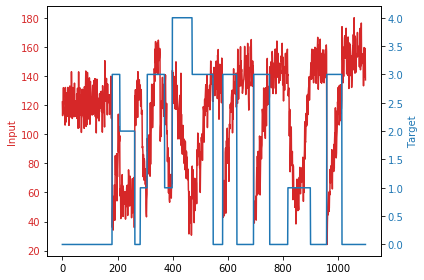

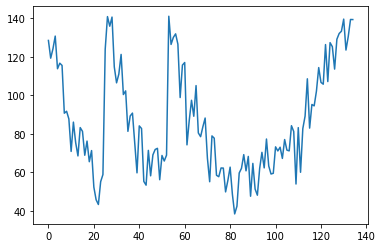

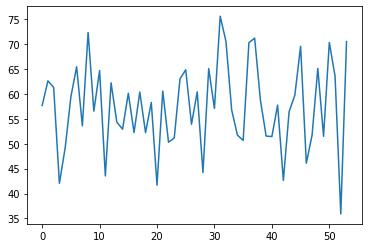

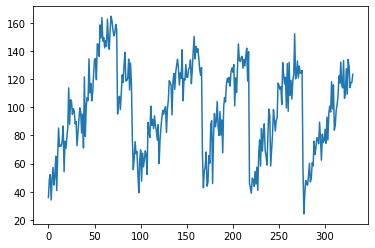

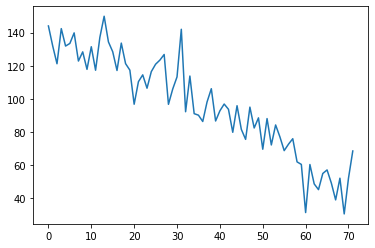

In [8]:
plot(GR_train_array[1,:], GR_train_target[1,:])

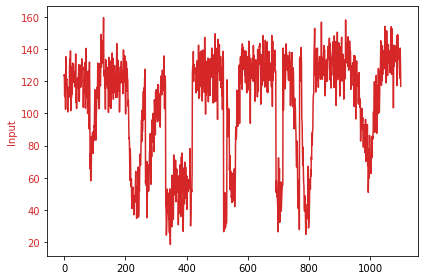

In [9]:
plot(GR_test_array[100,:])

In [10]:
GR_train_array = GR_train_array.reshape(GR_train_array.shape[0], GR_train_array.shape[1], 1)
GR_test_array = GR_test_array.reshape(GR_test_array.shape[0], GR_test_array.shape[1], 1)
GR_train_target = to_categorical(GR_train_target, num_classes=N_TAGS)

In [11]:
def get_model():
    word_in = Input(shape=(MAX_LEN, 1))
    x = word_in
    main_lstm = Bidirectional(LSTM(units=30, return_sequences=True, recurrent_dropout=0.4))(x)
    main_lstm = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.4))(main_lstm)
    main_lstm = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.4))(main_lstm)
    out = TimeDistributed(Dense(N_TAGS, activation="softmax"))(main_lstm)
    model = Model(word_in, out)
    model.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=['categorical_accuracy'])
    return model

In [12]:
model = get_model()

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1100, 1)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 1100, 60)          7680      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1100, 100)         44400     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 1100, 100)         60400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 1100, 5)           505       
Total params: 112,985
Trainable params: 112,985
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stop = EarlyStopping(monitor="val_loss", mode="min", patience=20)
checkpointer = ModelCheckpoint(filepath=SAVE + 'model.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger(SAVE + 'log.txt')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=8, verbose=1, factor=0.5, min_lr=1e-8)

In [15]:
model.fit(GR_train_array,
          GR_train_target,
          batch_size=BATCH_SIZE,
          epochs=MAX_EPOCH,
          validation_split=0.2,
          verbose=1,
          callbacks=[early_stop, checkpointer, csv_logger, learning_rate_reduction],
          shuffle=True)

Train on 3200 samples, validate on 800 samples
Epoch 1/1000
3200/3200 [==============================] - ETA: 1:48 - loss: 1.6550 - categorical_accuracy: 0.12 - ETA: 1:11 - loss: 1.6019 - categorical_accuracy: 0.26 - ETA: 50s - loss: 1.5529 - categorical_accuracy: 0.3554 - ETA: 33s - loss: 1.5144 - categorical_accuracy: 0.395 - ETA: 18s - loss: 1.4818 - categorical_accuracy: 0.421 - ETA: 3s - loss: 1.4602 - categorical_accuracy: 0.438 - 103s 32ms/step - loss: 1.4569 - categorical_accuracy: 0.4421 - val_loss: 1.3680 - val_categorical_accuracy: 0.5287

Epoch 00001: val_loss improved from inf to 1.36799, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 2/1000
3200/3200 [==============================] - ETA: 1:14 - loss: 1.3639 - categorical_accuracy: 0.52 - ETA: 1:01 - loss: 1.3594 - categorical_accuracy: 0.52 - ETA: 47s - loss: 1.3516 - categorical_accuracy: 0.5261 - ETA: 32s - loss: 1.3446 - categorical_accur

Epoch 00012: val_loss improved from 0.73465 to 0.67585, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 13/1000
3200/3200 [==============================] - ETA: 1:13 - loss: 0.7347 - categorical_accuracy: 0.70 - ETA: 59s - loss: 0.7349 - categorical_accuracy: 0.7081 - ETA: 45s - loss: 0.7277 - categorical_accuracy: 0.711 - ETA: 31s - loss: 0.7211 - categorical_accuracy: 0.714 - ETA: 17s - loss: 0.7186 - categorical_accuracy: 0.715 - ETA: 3s - loss: 0.7163 - categorical_accuracy: 0.716 - 98s 31ms/step - loss: 0.7156 - categorical_accuracy: 0.7172 - val_loss: 0.6301 - val_categorical_accuracy: 0.7510

Epoch 00013: val_loss improved from 0.67585 to 0.63013, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 14/1000
3200/3200 [==============================] - ETA: 1:14 - loss: 0.6860 - categorical_accuracy: 0.73 - ETA: 59s - loss: 0.68


Epoch 00024: val_loss improved from 0.30124 to 0.29196, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 25/1000
3200/3200 [==============================] - ETA: 1:14 - loss: 0.3312 - categorical_accuracy: 0.88 - ETA: 59s - loss: 0.3327 - categorical_accuracy: 0.8818 - ETA: 46s - loss: 0.3297 - categorical_accuracy: 0.883 - ETA: 31s - loss: 0.3278 - categorical_accuracy: 0.883 - ETA: 17s - loss: 0.3294 - categorical_accuracy: 0.883 - ETA: 3s - loss: 0.3297 - categorical_accuracy: 0.882 - 98s 31ms/step - loss: 0.3297 - categorical_accuracy: 0.8829 - val_loss: 0.2821 - val_categorical_accuracy: 0.9020

Epoch 00025: val_loss improved from 0.29196 to 0.28211, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 26/1000
3200/3200 [==============================] - ETA: 1:14 - loss: 0.3202 - categorical_accuracy: 0.88 - ETA: 1:00 - loss: 0.


Epoch 00036: val_loss improved from 0.22319 to 0.22053, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 37/1000
3200/3200 [==============================] - ETA: 1:24 - loss: 0.2506 - categorical_accuracy: 0.91 - ETA: 1:06 - loss: 0.2529 - categorical_accuracy: 0.91 - ETA: 51s - loss: 0.2524 - categorical_accuracy: 0.9121 - ETA: 35s - loss: 0.2503 - categorical_accuracy: 0.912 - ETA: 19s - loss: 0.2508 - categorical_accuracy: 0.912 - ETA: 3s - loss: 0.2507 - categorical_accuracy: 0.912 - 108s 34ms/step - loss: 0.2503 - categorical_accuracy: 0.9127 - val_loss: 0.2175 - val_categorical_accuracy: 0.9249

Epoch 00037: val_loss improved from 0.22053 to 0.21752, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 38/1000
3200/3200 [==============================] - ETA: 1:22 - loss: 0.2497 - categorical_accuracy: 0.91 - ETA: 1:06 - loss: 0


Epoch 00048: val_loss improved from 0.18556 to 0.18064, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 49/1000
3200/3200 [==============================] - ETA: 1:17 - loss: 0.2093 - categorical_accuracy: 0.92 - ETA: 1:03 - loss: 0.2088 - categorical_accuracy: 0.92 - ETA: 47s - loss: 0.2107 - categorical_accuracy: 0.9264 - ETA: 33s - loss: 0.2107 - categorical_accuracy: 0.926 - ETA: 18s - loss: 0.2097 - categorical_accuracy: 0.926 - ETA: 3s - loss: 0.2092 - categorical_accuracy: 0.927 - 103s 32ms/step - loss: 0.2094 - categorical_accuracy: 0.9269 - val_loss: 0.1808 - val_categorical_accuracy: 0.9372

Epoch 00049: val_loss did not improve from 0.18064
Epoch 50/1000
3200/3200 [==============================] - ETA: 1:14 - loss: 0.2056 - categorical_accuracy: 0.92 - ETA: 1:01 - loss: 0.2071 - categorical_accuracy: 0.92 - ETA: 49s - loss: 0.2083 - categorical_accuracy: 0.9272 - ETA: 34s - loss: 0.2087 - catego

3200/3200 [==============================] - ETA: 1:29 - loss: 0.1872 - categorical_accuracy: 0.93 - ETA: 1:11 - loss: 0.1880 - categorical_accuracy: 0.93 - ETA: 53s - loss: 0.1879 - categorical_accuracy: 0.9342 - ETA: 37s - loss: 0.1868 - categorical_accuracy: 0.934 - ETA: 20s - loss: 0.1868 - categorical_accuracy: 0.934 - ETA: 4s - loss: 0.1863 - categorical_accuracy: 0.934 - 115s 36ms/step - loss: 0.1862 - categorical_accuracy: 0.9345 - val_loss: 0.1594 - val_categorical_accuracy: 0.9433

Epoch 00061: val_loss improved from 0.16136 to 0.15943, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 62/1000
3200/3200 [==============================] - ETA: 1:26 - loss: 0.1898 - categorical_accuracy: 0.93 - ETA: 1:09 - loss: 0.1876 - categorical_accuracy: 0.93 - ETA: 52s - loss: 0.1866 - categorical_accuracy: 0.9339 - ETA: 36s - loss: 0.1851 - categorical_accuracy: 0.934 - ETA: 20s - loss: 0.1835 - categorical_accu

3200/3200 [==============================] - ETA: 1:12 - loss: 0.1699 - categorical_accuracy: 0.94 - ETA: 59s - loss: 0.1709 - categorical_accuracy: 0.9402 - ETA: 45s - loss: 0.1701 - categorical_accuracy: 0.940 - ETA: 31s - loss: 0.1695 - categorical_accuracy: 0.940 - ETA: 17s - loss: 0.1698 - categorical_accuracy: 0.940 - ETA: 3s - loss: 0.1690 - categorical_accuracy: 0.940 - 97s 30ms/step - loss: 0.1693 - categorical_accuracy: 0.9407 - val_loss: 0.1449 - val_categorical_accuracy: 0.9486

Epoch 00073: val_loss improved from 0.14638 to 0.14487, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 74/1000
3200/3200 [==============================] - ETA: 1:13 - loss: 0.1738 - categorical_accuracy: 0.93 - ETA: 1:00 - loss: 0.1710 - categorical_accuracy: 0.93 - ETA: 46s - loss: 0.1699 - categorical_accuracy: 0.9400 - ETA: 31s - loss: 0.1697 - categorical_accuracy: 0.940 - ETA: 17s - loss: 0.1691 - categorical_accur


Epoch 00085: val_loss improved from 0.13824 to 0.13520, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 86/1000
3200/3200 [==============================] - ETA: 1:13 - loss: 0.1574 - categorical_accuracy: 0.94 - ETA: 1:00 - loss: 0.1559 - categorical_accuracy: 0.94 - ETA: 45s - loss: 0.1578 - categorical_accuracy: 0.9448 - ETA: 31s - loss: 0.1574 - categorical_accuracy: 0.944 - ETA: 17s - loss: 0.1569 - categorical_accuracy: 0.945 - ETA: 3s - loss: 0.1570 - categorical_accuracy: 0.944 - 98s 31ms/step - loss: 0.1570 - categorical_accuracy: 0.9448 - val_loss: 0.1351 - val_categorical_accuracy: 0.9522

Epoch 00086: val_loss improved from 0.13520 to 0.13508, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 87/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1581 - categorical_accuracy: 0.94 - ETA: 59s - loss: 0.1


Epoch 00098: val_loss improved from 0.12844 to 0.12741, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 99/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1446 - categorical_accuracy: 0.94 - ETA: 58s - loss: 0.1443 - categorical_accuracy: 0.9494 - ETA: 44s - loss: 0.1457 - categorical_accuracy: 0.948 - ETA: 31s - loss: 0.1465 - categorical_accuracy: 0.948 - ETA: 17s - loss: 0.1467 - categorical_accuracy: 0.948 - ETA: 3s - loss: 0.1467 - categorical_accuracy: 0.948 - 96s 30ms/step - loss: 0.1463 - categorical_accuracy: 0.9484 - val_loss: 0.1269 - val_categorical_accuracy: 0.9548

Epoch 00099: val_loss improved from 0.12741 to 0.12690, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 100/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1468 - categorical_accuracy: 0.94 - ETA: 58s - loss: 0.

Epoch 00111: val_loss did not improve from 0.12118
Epoch 112/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1428 - categorical_accuracy: 0.95 - ETA: 59s - loss: 0.1411 - categorical_accuracy: 0.9504 - ETA: 45s - loss: 0.1402 - categorical_accuracy: 0.950 - ETA: 31s - loss: 0.1388 - categorical_accuracy: 0.951 - ETA: 17s - loss: 0.1381 - categorical_accuracy: 0.951 - ETA: 3s - loss: 0.1381 - categorical_accuracy: 0.951 - 97s 30ms/step - loss: 0.1383 - categorical_accuracy: 0.9513 - val_loss: 0.1213 - val_categorical_accuracy: 0.9571

Epoch 00112: val_loss did not improve from 0.12118
Epoch 113/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1369 - categorical_accuracy: 0.95 - ETA: 59s - loss: 0.1372 - categorical_accuracy: 0.9516 - ETA: 45s - loss: 0.1383 - categorical_accuracy: 0.951 - ETA: 31s - loss: 0.1378 - categorical_accuracy: 0.951 - ETA: 17s - loss: 0.1370 - categorical_accuracy: 0.951 - ETA: 3s - loss: 0.1375 - categorical_accuracy:

Epoch 00124: val_loss did not improve from 0.11697
Epoch 125/1000
3200/3200 [==============================] - ETA: 1:13 - loss: 0.1351 - categorical_accuracy: 0.95 - ETA: 58s - loss: 0.1314 - categorical_accuracy: 0.9534 - ETA: 44s - loss: 0.1325 - categorical_accuracy: 0.953 - ETA: 31s - loss: 0.1331 - categorical_accuracy: 0.952 - ETA: 17s - loss: 0.1326 - categorical_accuracy: 0.953 - ETA: 3s - loss: 0.1324 - categorical_accuracy: 0.953 - 96s 30ms/step - loss: 0.1326 - categorical_accuracy: 0.9533 - val_loss: 0.1160 - val_categorical_accuracy: 0.9589

Epoch 00125: val_loss improved from 0.11697 to 0.11597, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 126/1000
3200/3200 [==============================] - ETA: 1:13 - loss: 0.1314 - categorical_accuracy: 0.95 - ETA: 58s - loss: 0.1316 - categorical_accuracy: 0.9535 - ETA: 44s - loss: 0.1302 - categorical_accuracy: 0.954 - ETA: 31s - loss: 0.1310 - catego

3200/3200 [==============================] - ETA: 1:12 - loss: 0.1270 - categorical_accuracy: 0.95 - ETA: 58s - loss: 0.1267 - categorical_accuracy: 0.9558 - ETA: 44s - loss: 0.1269 - categorical_accuracy: 0.955 - ETA: 31s - loss: 0.1272 - categorical_accuracy: 0.955 - ETA: 17s - loss: 0.1276 - categorical_accuracy: 0.955 - ETA: 3s - loss: 0.1278 - categorical_accuracy: 0.955 - 96s 30ms/step - loss: 0.1278 - categorical_accuracy: 0.9551 - val_loss: 0.1123 - val_categorical_accuracy: 0.9604

Epoch 00138: val_loss did not improve from 0.11210
Epoch 139/1000
3200/3200 [==============================] - ETA: 1:13 - loss: 0.1231 - categorical_accuracy: 0.95 - ETA: 59s - loss: 0.1252 - categorical_accuracy: 0.9563 - ETA: 45s - loss: 0.1253 - categorical_accuracy: 0.955 - ETA: 31s - loss: 0.1267 - categorical_accuracy: 0.955 - ETA: 17s - loss: 0.1260 - categorical_accuracy: 0.955 - ETA: 3s - loss: 0.1272 - categorical_accuracy: 0.955 - 97s 30ms/step - loss: 0.1274 - categorical_accuracy: 0.95

3200/3200 [==============================] - ETA: 1:12 - loss: 0.1217 - categorical_accuracy: 0.95 - ETA: 58s - loss: 0.1207 - categorical_accuracy: 0.9571 - ETA: 44s - loss: 0.1219 - categorical_accuracy: 0.956 - ETA: 30s - loss: 0.1229 - categorical_accuracy: 0.956 - ETA: 17s - loss: 0.1231 - categorical_accuracy: 0.956 - ETA: 3s - loss: 0.1233 - categorical_accuracy: 0.956 - 96s 30ms/step - loss: 0.1234 - categorical_accuracy: 0.9563 - val_loss: 0.1102 - val_categorical_accuracy: 0.9609

Epoch 00151: val_loss did not improve from 0.10965
Epoch 152/1000
3200/3200 [==============================] - ETA: 1:13 - loss: 0.1223 - categorical_accuracy: 0.95 - ETA: 59s - loss: 0.1217 - categorical_accuracy: 0.9567 - ETA: 45s - loss: 0.1227 - categorical_accuracy: 0.956 - ETA: 31s - loss: 0.1231 - categorical_accuracy: 0.956 - ETA: 17s - loss: 0.1234 - categorical_accuracy: 0.956 - ETA: 3s - loss: 0.1232 - categorical_accuracy: 0.956 - 97s 30ms/step - loss: 0.1229 - categorical_accuracy: 0.95

Epoch 00163: val_loss improved from 0.10747 to 0.10632, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 164/1000
3200/3200 [==============================] - ETA: 1:15 - loss: 0.1192 - categorical_accuracy: 0.95 - ETA: 59s - loss: 0.1205 - categorical_accuracy: 0.9573 - ETA: 45s - loss: 0.1207 - categorical_accuracy: 0.957 - ETA: 31s - loss: 0.1210 - categorical_accuracy: 0.956 - ETA: 17s - loss: 0.1206 - categorical_accuracy: 0.957 - ETA: 3s - loss: 0.1201 - categorical_accuracy: 0.957 - 97s 30ms/step - loss: 0.1201 - categorical_accuracy: 0.9575 - val_loss: 0.1077 - val_categorical_accuracy: 0.9618

Epoch 00164: val_loss did not improve from 0.10632
Epoch 165/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1237 - categorical_accuracy: 0.95 - ETA: 59s - loss: 0.1228 - categorical_accuracy: 0.9569 - ETA: 45s - loss: 0.1214 - categorical_accuracy: 0.957 - ETA: 31s - loss: 0.1213 - catego

3200/3200 [==============================] - ETA: 1:12 - loss: 0.1165 - categorical_accuracy: 0.95 - ETA: 58s - loss: 0.1168 - categorical_accuracy: 0.9586 - ETA: 45s - loss: 0.1167 - categorical_accuracy: 0.958 - ETA: 31s - loss: 0.1171 - categorical_accuracy: 0.958 - ETA: 17s - loss: 0.1167 - categorical_accuracy: 0.958 - ETA: 3s - loss: 0.1163 - categorical_accuracy: 0.958 - 98s 30ms/step - loss: 0.1163 - categorical_accuracy: 0.9590 - val_loss: 0.1047 - val_categorical_accuracy: 0.9629

Epoch 00177: val_loss improved from 0.10478 to 0.10465, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 178/1000
3200/3200 [==============================] - ETA: 1:16 - loss: 0.1182 - categorical_accuracy: 0.95 - ETA: 59s - loss: 0.1157 - categorical_accuracy: 0.9592 - ETA: 45s - loss: 0.1165 - categorical_accuracy: 0.959 - ETA: 31s - loss: 0.1162 - categorical_accuracy: 0.959 - ETA: 17s - loss: 0.1155 - categorical_accu

Epoch 00190: val_loss improved from 0.10371 to 0.10325, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 191/1000
3200/3200 [==============================] - ETA: 1:15 - loss: 0.1138 - categorical_accuracy: 0.96 - ETA: 1:00 - loss: 0.1133 - categorical_accuracy: 0.96 - ETA: 46s - loss: 0.1147 - categorical_accuracy: 0.9596 - ETA: 31s - loss: 0.1147 - categorical_accuracy: 0.959 - ETA: 17s - loss: 0.1130 - categorical_accuracy: 0.960 - ETA: 3s - loss: 0.1137 - categorical_accuracy: 0.959 - 98s 31ms/step - loss: 0.1139 - categorical_accuracy: 0.9598 - val_loss: 0.1033 - val_categorical_accuracy: 0.9632

Epoch 00191: val_loss did not improve from 0.10325
Epoch 192/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1155 - categorical_accuracy: 0.95 - ETA: 58s - loss: 0.1146 - categorical_accuracy: 0.9598 - ETA: 44s - loss: 0.1155 - categorical_accuracy: 0.959 - ETA: 30s - loss: 0.1157 - catego

3200/3200 [==============================] - ETA: 1:11 - loss: 0.1090 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1103 - categorical_accuracy: 0.9614 - ETA: 44s - loss: 0.1112 - categorical_accuracy: 0.961 - ETA: 31s - loss: 0.1113 - categorical_accuracy: 0.961 - ETA: 17s - loss: 0.1113 - categorical_accuracy: 0.960 - ETA: 3s - loss: 0.1111 - categorical_accuracy: 0.960 - 96s 30ms/step - loss: 0.1109 - categorical_accuracy: 0.9609 - val_loss: 0.1015 - val_categorical_accuracy: 0.9639

Epoch 00204: val_loss improved from 0.10187 to 0.10154, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 205/1000
3200/3200 [==============================] - ETA: 1:11 - loss: 0.1110 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1123 - categorical_accuracy: 0.9602 - ETA: 45s - loss: 0.1114 - categorical_accuracy: 0.960 - ETA: 31s - loss: 0.1104 - categorical_accuracy: 0.961 - ETA: 17s - loss: 0.1106 - categorical_accu

3200/3200 [==============================] - ETA: 1:11 - loss: 0.1108 - categorical_accuracy: 0.96 - ETA: 59s - loss: 0.1088 - categorical_accuracy: 0.9623 - ETA: 45s - loss: 0.1085 - categorical_accuracy: 0.962 - ETA: 31s - loss: 0.1082 - categorical_accuracy: 0.962 - ETA: 17s - loss: 0.1083 - categorical_accuracy: 0.961 - ETA: 3s - loss: 0.1083 - categorical_accuracy: 0.961 - 96s 30ms/step - loss: 0.1084 - categorical_accuracy: 0.9618 - val_loss: 0.1007 - val_categorical_accuracy: 0.9643

Epoch 00217: val_loss did not improve from 0.10019
Epoch 218/1000
3200/3200 [==============================] - ETA: 1:11 - loss: 0.1085 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1080 - categorical_accuracy: 0.9616 - ETA: 45s - loss: 0.1084 - categorical_accuracy: 0.961 - ETA: 31s - loss: 0.1083 - categorical_accuracy: 0.961 - ETA: 17s - loss: 0.1084 - categorical_accuracy: 0.961 - ETA: 3s - loss: 0.1083 - categorical_accuracy: 0.961 - 96s 30ms/step - loss: 0.1083 - categorical_accuracy: 0.96

Epoch 00230: val_loss improved from 0.09929 to 0.09923, saving model to D:/Concursos_Kaggle/33_Gamma Log Facies Type Prediction/20_solution/Resultados/01_tratamiento/model.hdf5
Epoch 231/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1077 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1069 - categorical_accuracy: 0.9623 - ETA: 44s - loss: 0.1051 - categorical_accuracy: 0.963 - ETA: 31s - loss: 0.1062 - categorical_accuracy: 0.962 - ETA: 17s - loss: 0.1071 - categorical_accuracy: 0.962 - ETA: 3s - loss: 0.1067 - categorical_accuracy: 0.962 - 96s 30ms/step - loss: 0.1065 - categorical_accuracy: 0.9623 - val_loss: 0.1006 - val_categorical_accuracy: 0.9644

Epoch 00231: val_loss did not improve from 0.09923
Epoch 232/1000
3200/3200 [==============================] - ETA: 1:12 - loss: 0.1074 - categorical_accuracy: 0.96 - ETA: 59s - loss: 0.1072 - categorical_accuracy: 0.9624 - ETA: 44s - loss: 0.1077 - categorical_accuracy: 0.961 - ETA: 31s - loss: 0.1074 - catego

3200/3200 [==============================] - ETA: 1:12 - loss: 0.1067 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1062 - categorical_accuracy: 0.9626 - ETA: 45s - loss: 0.1051 - categorical_accuracy: 0.963 - ETA: 31s - loss: 0.1060 - categorical_accuracy: 0.962 - ETA: 17s - loss: 0.1060 - categorical_accuracy: 0.962 - ETA: 3s - loss: 0.1057 - categorical_accuracy: 0.962 - 97s 30ms/step - loss: 0.1058 - categorical_accuracy: 0.9627 - val_loss: 0.0980 - val_categorical_accuracy: 0.9651

Epoch 00244: val_loss did not improve from 0.09772
Epoch 245/1000
3200/3200 [==============================] - ETA: 1:13 - loss: 0.1055 - categorical_accuracy: 0.96 - ETA: 59s - loss: 0.1054 - categorical_accuracy: 0.9625 - ETA: 45s - loss: 0.1048 - categorical_accuracy: 0.962 - ETA: 31s - loss: 0.1047 - categorical_accuracy: 0.963 - ETA: 17s - loss: 0.1047 - categorical_accuracy: 0.963 - ETA: 3s - loss: 0.1048 - categorical_accuracy: 0.963 - 96s 30ms/step - loss: 0.1050 - categorical_accuracy: 0.96


Epoch 00257: val_loss did not improve from 0.09700
Epoch 258/1000
3200/3200 [==============================] - ETA: 1:11 - loss: 0.1065 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1034 - categorical_accuracy: 0.9640 - ETA: 44s - loss: 0.1036 - categorical_accuracy: 0.963 - ETA: 31s - loss: 0.1033 - categorical_accuracy: 0.963 - ETA: 17s - loss: 0.1027 - categorical_accuracy: 0.963 - ETA: 3s - loss: 0.1023 - categorical_accuracy: 0.963 - 96s 30ms/step - loss: 0.1028 - categorical_accuracy: 0.9638 - val_loss: 0.0977 - val_categorical_accuracy: 0.9653

Epoch 00258: val_loss did not improve from 0.09700
Epoch 259/1000
3200/3200 [==============================] - ETA: 1:11 - loss: 0.1070 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1070 - categorical_accuracy: 0.9626 - ETA: 44s - loss: 0.1051 - categorical_accuracy: 0.963 - ETA: 31s - loss: 0.1044 - categorical_accuracy: 0.963 - ETA: 17s - loss: 0.1037 - categorical_accuracy: 0.963 - ETA: 3s - loss: 0.1034 - categorical_accuracy

3200/3200 [==============================] - ETA: 1:13 - loss: 0.0994 - categorical_accuracy: 0.96 - ETA: 59s - loss: 0.1011 - categorical_accuracy: 0.9640 - ETA: 45s - loss: 0.1017 - categorical_accuracy: 0.963 - ETA: 31s - loss: 0.1021 - categorical_accuracy: 0.963 - ETA: 17s - loss: 0.1027 - categorical_accuracy: 0.963 - ETA: 3s - loss: 0.1023 - categorical_accuracy: 0.963 - 97s 30ms/step - loss: 0.1021 - categorical_accuracy: 0.9638 - val_loss: 0.0965 - val_categorical_accuracy: 0.9657

Epoch 00271: val_loss did not improve from 0.09624
Epoch 272/1000
3200/3200 [==============================] - ETA: 1:14 - loss: 0.1005 - categorical_accuracy: 0.96 - ETA: 59s - loss: 0.1025 - categorical_accuracy: 0.9641 - ETA: 45s - loss: 0.1027 - categorical_accuracy: 0.964 - ETA: 31s - loss: 0.1026 - categorical_accuracy: 0.963 - ETA: 17s - loss: 0.1024 - categorical_accuracy: 0.964 - ETA: 3s - loss: 0.1018 - categorical_accuracy: 0.964 - 98s 30ms/step - loss: 0.1017 - categorical_accuracy: 0.96

3200/3200 [==============================] - ETA: 1:12 - loss: 0.1034 - categorical_accuracy: 0.96 - ETA: 59s - loss: 0.1028 - categorical_accuracy: 0.9638 - ETA: 45s - loss: 0.1012 - categorical_accuracy: 0.964 - ETA: 31s - loss: 0.1013 - categorical_accuracy: 0.964 - ETA: 17s - loss: 0.1015 - categorical_accuracy: 0.964 - ETA: 3s - loss: 0.1017 - categorical_accuracy: 0.964 - 97s 30ms/step - loss: 0.1016 - categorical_accuracy: 0.9643 - val_loss: 0.0962 - val_categorical_accuracy: 0.9659

Epoch 00285: val_loss did not improve from 0.09616
Epoch 286/1000
3200/3200 [==============================] - ETA: 1:15 - loss: 0.1016 - categorical_accuracy: 0.96 - ETA: 1:00 - loss: 0.1022 - categorical_accuracy: 0.96 - ETA: 45s - loss: 0.1024 - categorical_accuracy: 0.9643 - ETA: 31s - loss: 0.1011 - categorical_accuracy: 0.964 - ETA: 17s - loss: 0.1009 - categorical_accuracy: 0.964 - ETA: 3s - loss: 0.1008 - categorical_accuracy: 0.964 - 97s 30ms/step - loss: 0.1009 - categorical_accuracy: 0.96

3200/3200 [==============================] - ETA: 1:11 - loss: 0.1009 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1017 - categorical_accuracy: 0.9641 - ETA: 44s - loss: 0.1025 - categorical_accuracy: 0.963 - ETA: 31s - loss: 0.1027 - categorical_accuracy: 0.963 - ETA: 17s - loss: 0.1025 - categorical_accuracy: 0.963 - ETA: 3s - loss: 0.1018 - categorical_accuracy: 0.964 - 96s 30ms/step - loss: 0.1016 - categorical_accuracy: 0.9641 - val_loss: 0.0962 - val_categorical_accuracy: 0.9659

Epoch 00299: val_loss did not improve from 0.09610
Epoch 300/1000
3200/3200 [==============================] - ETA: 1:11 - loss: 0.1019 - categorical_accuracy: 0.96 - ETA: 58s - loss: 0.1003 - categorical_accuracy: 0.9644 - ETA: 45s - loss: 0.1012 - categorical_accuracy: 0.964 - ETA: 31s - loss: 0.1010 - categorical_accuracy: 0.964 - ETA: 17s - loss: 0.1012 - categorical_accuracy: 0.964 - ETA: 3s - loss: 0.1011 - categorical_accuracy: 0.964 - 97s 30ms/step - loss: 0.1014 - categorical_accuracy: 0.96

In [16]:
# LOAD MODEL
best_model = load_model(SAVE + 'model.hdf5')

In [17]:
# PREDICT MODEL
pred_test = best_model.predict(GR_test_array, batch_size=4096, verbose=1)

2000/2000 [==============================] - 4s 2ms/step


In [18]:
pred_test_class = np.argmax(pred_test, axis=-1)

In [19]:
pred_test_list = pred_test_class.tolist()

In [20]:
pred_test_subir = []

for list_ in tqdm.tqdm(pred_test_list):
    pred_test_subir = pred_test_subir + list_

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:11<00:00, 171.85it/s]


In [21]:
# UPLOAD PREDICTIONS
data_subir = pd.DataFrame({'unique_id': data_test.unique_id,
                           'label': pred_test_subir})

In [22]:
data_subir.to_csv(SAVE + 'submission.csv', index=False)